# Exploring SAT scores in New York City
---

We explore relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:
- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## Data import & pre-processing
---
### Importing the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Importing the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analysis
---
### Finding correlations

In [9]:
correlations = combined.corr()

We are only interested in the correlations of SAT scores with respect to all the other columns, so we only keep the correlations in the `sat_score` column:

In [10]:
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Let's display the correlations of SAT scores with each of these columns as a bar plot.  To make it more readable, we map the column codes to their description according to the [survey data dictionary](https://data.cityofnewyork.us/Education/2010-2011-NYC-School-Survey/mnz3-dyi8):

                             sat_score
Survey fields                         
DBN                                NaN
Student Response Rate         0.232199
Teacher Response Rate        -0.023386
Parent Response Rate          0.047925
Number of eligible students   0.423463


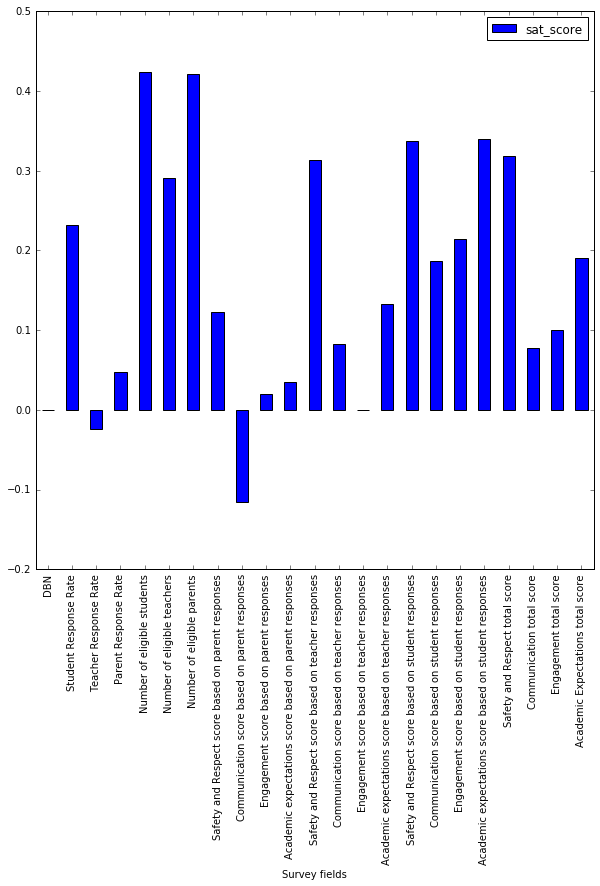

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

corr_survey_fields = pd.DataFrame(correlations[survey_fields])

corr_survey_fields['Survey fields'] = ['DBN','Student Response Rate',
'Teacher Response Rate',
'Parent Response Rate',
'Number of eligible students',
'Number of eligible teachers',
'Number of eligible parents',
'Safety and Respect score based on parent responses',
'Communication score based on parent responses',
'Engagement score based on parent responses',
'Academic expectations score based on parent responses',
'Safety and Respect score based on teacher responses',
'Communication score based on teacher responses',
'Engagement score based on teacher responses',
'Academic expectations score based on teacher responses',
'Safety and Respect score based on student responses',
'Communication score based on student responses',
'Engagement score based on student responses',
'Academic expectations score based on student responses',
'Safety and Respect total score',
'Communication total score',
'Engagement total score',
'Academic Expectations total score',
]

print(corr_survey_fields.set_index('Survey fields').head())
corr_survey_fields.plot.bar(x='Survey fields', y='sat_score', figsize=(10,10))
plt.legend()
plt.show()

Interestingly, the columns `Teacher Response Rate` and `Communication score based on parent responses` are negatively correlated to SAT scores.  The columns `Number of eligible students` and `Number of eligible parents` are strongly correlated to SAT scores.

### Safety scores vs SAT scores

Let's investigate the relationship between SAT scores and the column `saf_s_11`.  According to the plot above, this column is positively correlated to SAT scores.

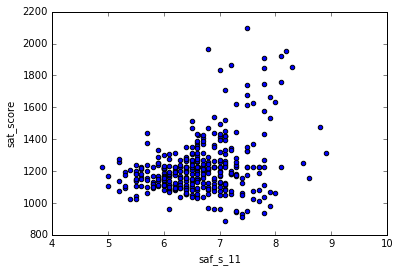

In [12]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

Although we obtained a positive correlation, we see here that the correlation is not so strong.  There is an aggregation of data for low SAT scores and schools with low safety scores. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Mapping satety scores
Let's map out the safety scores.

In [13]:
import numpy as np
avg_by_dist = combined.groupby('school_dist').agg(np.mean)
avg_by_dist['saf_s_11'].head()

school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
Name: saf_s_11, dtype: float64

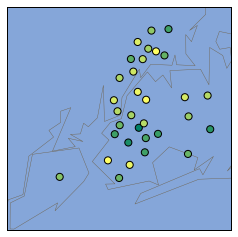

In [14]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.scatter(avg_by_dist['lon'].tolist(), avg_by_dist['lat'].tolist(), s=50, zorder=2, latlon=True, c=avg_by_dist['saf_s_11'], cmap='summer')
plt.show()

In green, we have districts with low safety scores.  In yellow, districts with high safety scores.  We see that Brooklyn has a majority of schools with low safety scores (see this [page](https://www.nycgo.com/boroughs-neighborhoods) to have a description of New York City boroughs).

### Investigating racial differences in SAT scores

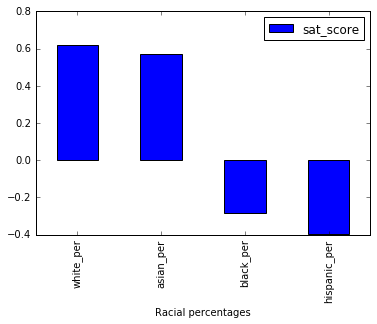

In [19]:
racial_per = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[racial_per].plot.bar()
plt.legend()
plt.xlabel('Racial percentages')
plt.show()

We see that the columns `white-per` and `asian_per` are positively correlated with SAT scores, while `black_per` and `hispanic_per` are negatively correlated.

### Investigating schools with low SAT scores and high values for `hispanic_per`

We here make a scatter plot of `hispanic_per` versus `sat_score` for schools with `hispanic_per` greater than 95%.

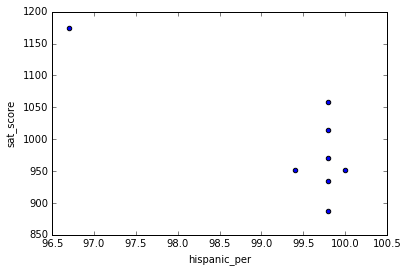

In [31]:
combined[combined['hispanic_per'] > 95].plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.show()

What are the school names?

In [34]:
combined[['SCHOOL NAME', 'hispanic_per','sat_score']][combined['hispanic_per']>95]

,SCHOOL NAME,hispanic_per,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0
253,MULTICULTURAL HIGH SCHOOL,99.8,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0


### Investigating schools with high SAT scores and low values for hispanic_per

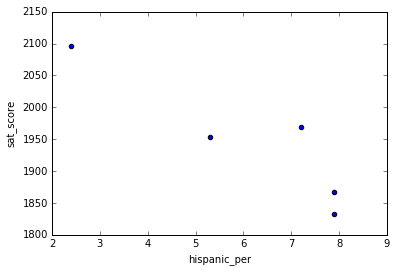

In [35]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)].plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.show()

In [36]:
combined[['SCHOOL NAME', 'hispanic_per','sat_score']][(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0


From investigations on the web, the Stuyvesant High School is "the most selective school of the nine specialized high schools in New York City, United States" ([Wikipedia](https://en.wikipedia.org/wiki/Stuyvesant_High_School)) Actually, all these schools are part of the "nine specialized high schools" in New York City, "to serve the needs of academically and artistically gifted students" ([Wikipedia](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City))

### Investigating gender differences in SAT scores

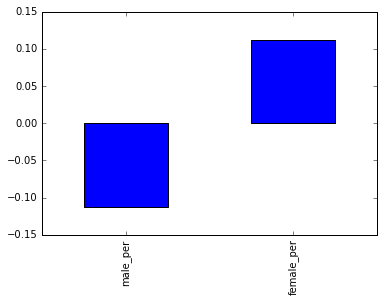

In [37]:
correlations[['male_per','female_per']].plot.bar()

This is quite speaking! :-)

### Investigating schools with high SAT scores and high `female_per`

Let's investigate schools with high SAT scores and high `female_per`.  Let's start with a scatter plot.

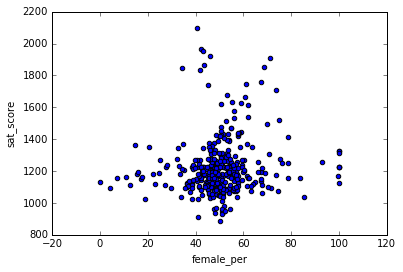

In [38]:
combined.plot(kind='scatter',x='female_per',y='sat_score')

This scatter plot shows a high concentration of schools with middle female percentage and low SAT scores.  Let's focus on schools with SAT scores higher than 1700 and female percentage above 60%.

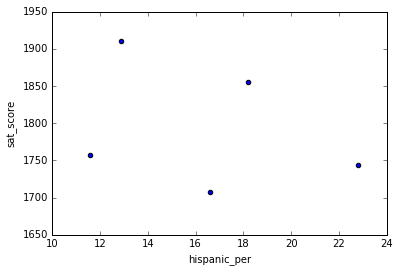

In [39]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)].plot(kind='scatter', x='hispanic_per', y='sat_score')

In [40]:
combined[['SCHOOL NAME', 'hispanic_per','sat_score']][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

,SCHOOL NAME,hispanic_per,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,18.2,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,11.6,1758.0
60,BEACON HIGH SCHOOL,22.8,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,16.6,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,12.9,1910.0


### Investigating the relationship with AP Test Takers
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.  

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [41]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

Let's start with a scatter plot.

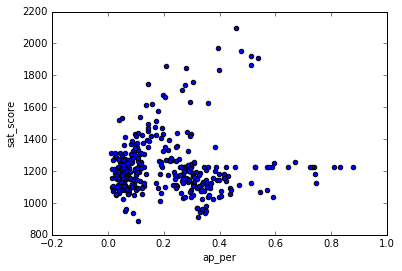

In [42]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')

We observe a high concentration of schools with low ap_per and SAT scores below 1400.  No schools with very high ap_per and very high SAT scores.